In [1]:
animal = 'AE2'
unit = '001'
trial = '021'

file_path = 'D:\\2P_data\\F\\%s\\u%s_%s\\1\\F_%s_u%s_%s_plane1_proc.mat' % (animal, unit, trial, animal, unit, trial)
analyzer_path = 'F:\\NHP\\AE2\\AnalyzerFiles\\%s\\%s_u%s_%s.analyzer' % (animal, animal, unit, trial)
plot = 'y'

In [2]:
import scipy.io as sio
import functions

F = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)['dat']
params = functions.analyzer_params(analyzer_path)
trial_num, stim_time = functions.analyzer_pg_conds(analyzer_path)
trial_num['direction'] = trial_num.ori
trial_num.ori[(trial_num.ori >= 180) & (trial_num.ori != 256)] = trial_num.ori[(trial_num.ori >= 180) &
                                                                               (trial_num.ori != 256)] - 180

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

mean_image = F.mimg[:, :, 1]
color_mask = np.zeros(mean_image.shape)
pref_cells = pd.DataFrame(columns=['expt', 'x', 'y', 'color_pref'])
osi_df = pd.DataFrame(columns=['expt', 'x', 'y', 'r_pref', 'r_orth', 'osi', 'color_pref'])
color_hex = ['#af1600', '#8a4600', '#5a5d01', '#2a6600', '#006a00', '#006931', '#006464', '#0058b6', '#002DFF', '#6a2ade', '#97209b', '#aa1c50']

for i, cell in enumerate(F.stat):
    if cell.iscell == 1:
        scans = int(F.Fcell.shape[1] / trial_num.shape[0])
        t = np.linspace(stim_time[0] * -1, stim_time.sum() - stim_time[1], scans)
        cell_F = pd.DataFrame(np.reshape(F.Fcell[i, :], (int(F.Fcell.shape[1] / scans), scans)))
        cell_F.insert(0, 'Orientation', trial_num.ori)
        cell_F.insert(1, 'Direction', trial_num.direction)
        cell_F.insert(2, 'Spatial Frequency', trial_num.s_freq)
        cell_F.insert(3, 'Color', trial_num.colormod)
        cell_F.insert(4, 'Baseline',
                      np.reshape(F.Fcell[i, :], (int(F.Fcell.shape[1] / scans), scans))
                      [:, 0:int(np.floor(scans * stim_time[0] / stim_time.sum())) - 1].mean(axis=1))
        
        start_sample = int(np.ceil(scans * (stim_time[0] + 0.5) / stim_time.sum()))
        end_sample = int(scans - np.ceil(scans * (stim_time[1]) / stim_time.sum()))
        
        cell_F.iloc[:, -scans:] = cell_F.iloc[:, -scans:].subtract(cell_F['Baseline'], axis=0).divide(cell_F['Baseline'],
                                                                                                  axis=0)
        
        cell_F_stim = pd.DataFrame(cell_F.iloc[:, -(scans-start_sample):-(scans-end_sample)].mean(axis=1), columns=['Mean'])
        cell_F_stim.insert(0, 'Orientation', trial_num.ori)
        cell_F_stim.insert(1, 'Direction', trial_num.direction)
        cell_F_stim.insert(2, 'Spatial Frequency', trial_num.s_freq)
        cell_F_stim.insert(3, 'Color', trial_num.colormod)
        
        max_response = cell_F_stim.groupby('Color').mean()['Mean'].max()
        
        # Calculate OSI and save into DataFrame
        x_med, y_med = cell.med
        counts_ori = cell_F_stim.groupby(['Orientation', 'Spatial Frequency']).mean()
        counts_sf = cell_F_stim.groupby(['Spatial Frequency', 'Orientation']).mean()
        sem_ori = cell_F_stim.groupby(['Orientation', 'Spatial Frequency']).sem()
        sem_sf = cell_F_stim.groupby(['Spatial Frequency', 'Orientation']).sem()
        
        s_freq_max = counts_ori.unstack(level=1).mean(axis=0).idxmax()
        orientation_max = counts_ori.unstack(level=1).mean(axis=1).idxmax()
        ori_pref = counts_sf['Mean'][s_freq_max[1]].idxmax()
        r_pref = counts_sf['Mean'][s_freq_max[1]].loc[ori_pref]
        if ori_pref < 90:
            ori_orth = ori_pref + 90
        else:
            ori_orth = ori_pref - 90
        r_orth = counts_sf['Mean'][s_freq_max[1]].loc[ori_orth]
        osi = (r_pref - r_orth) / r_pref
        
        osi_df.loc[i] = [analyzer_path[-17:-9], x_med, y_med, r_pref, r_orth, osi, 0]
        
        colors = np.unique(trial_num.colormod.values)
        list_F_stim = [cell_F_stim[cell_F_stim['Color'] == color]['Mean'] for color in colors]
        F_value, p = sp.stats.f_oneway(*list_F_stim)
        
        if p < 0.001:
            max_response = cell_F_stim.groupby('Color').mean()['Mean'].max()
            if max_response > 0.04:
                max_color = cell_F_stim.groupby('Color').mean()['Mean'].idxmax()
                if max_color < 16:
                    ortho_color = max_color + 6
                else:
                    ortho_color = max_color - 6
                ortho_response = cell_F_stim.groupby('Color').mean()['Mean'][ortho_color]
                color_si = (max_response - ortho_response) / max_response
                if color_si > 0.7:
                    color_mask[(cell.ypix - 1), (cell.xpix - 1)] = max_color
                    if plot == 'y':
                        plt.ioff()
                        fig, ax = plt.subplots()
                        ax.scatter(cell_F_stim.groupby('Color').mean()['Mean'].index.values, cell_F_stim.groupby('Color').mean()['Mean'].values, color=color_hex, s=100, zorder=2)
                        ax.fill_between(cell_F_stim.groupby('Color').mean()['Mean'].index.values, 
                                        cell_F_stim.groupby('Color').mean()['Mean'] - cell_F_stim.groupby('Color').sem()['Mean'],
                                        cell_F_stim.groupby('Color').mean()['Mean'] + cell_F_stim.groupby('Color').sem()['Mean'],
                                        alpha=0.5, color='#808080', zorder=1)
                        ax.xaxis.set_ticks([])
                        ax.set_ylabel(r'Response ($\Delta F/F$)')
                        plt.savefig('D:/nhp_cells/cell%d.pdf' % i, format='pdf')
                        plt.close()
                    pref_cells.loc[i] = [analyzer_path[-17:-9], x_med, y_med, max_color]                    
                    osi_df.loc[i, 'color_pref'] = 1

pref_cells.to_csv('D:/nhp_cells/%s_color_pref_df.csv' % analyzer_path[-17:-9])
osi_df.to_csv('D:/nhp_cells/color_osi/%s_color_osi_df.csv' % analyzer_path[-17:-9])

In [56]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import ColorConverter
# colors = ['#BA0000', '#C03100', '#D3ED00', '#3AF000', '#09F300', '#0AF125', '#0FEBAD', '#032EB3', '#000091', '#23009B', '#1200A2', '#B50020']
colors = ['#af1600', '#8a4600', '#5a5d01', '#2a6600', '#006a00', '#006931', '#006464', '#0058b6', '#002DFF', '#6a2ade', '#97209b', '#aa1c50']
cmap = ListedColormap(colors, 'indexed')
cmap.set_under(ColorConverter.to_rgba('white', alpha=0))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mean_image, cmap='gray', alpha=0.8)
im = ax.imshow(color_mask, cmap=cmap, vmin=10)
cb = fig.colorbar(im)
cb.set_ticks([])
cb.set_label('Preferred Color')
plt.axis('off')
plt.savefig('D:/nhp_cells/%s_color_map.pdf' % analyzer_path[-17:-9], format='pdf', bbox_inches='tight')
np.save('D:/nhp_cells/%s_color_map.npy' % analyzer_path[-17:-9], color_mask)
plt.close()

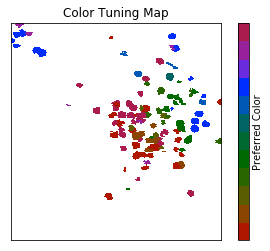

In [57]:
import glob
color_map_files = glob.glob('D:\\nhp_cells\\*color_map.npy')
fig, ax = plt.subplots()
for file in color_map_files:
    color_map = np.load(file)
    ax.imshow(color_map, cmap=cmap, vmin=10, vmax=21)
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(im)
cb.set_ticks([])
cb.set_label('Preferred Color')
plt.title('Color Tuning Map')
plt.savefig('D:/nhp_cells/color_map_all.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [170]:
color_pref_files = glob.glob('H:\\nhp_cells\\*color_pref_df.csv')
list_ = []
for file in color_pref_files:
    df = pd.read_csv(file, index_col=0, header=0)
    list_.append(df)
color_pref_all = pd.concat(list_)

In [171]:
color_pref_rb = color_pref_all[(color_pref_all.color_pref == 17) | (color_pref_all.color_pref == 10)]

In [172]:
from matplotlib.colors import Normalize
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
X = color_pref_rb[['x', 'y']].as_matrix()
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = color_pref_rb[['color_pref']].as_matrix().ravel()

clf = svm.NuSVC()
clf.fit(X, Y)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
ax.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
          origin='lower', cmap='jet_r')
contours = ax.contour(xx, yy, Z, levels=[-0.5, .5], linewidths=1, colors='k')
scat = ax.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=cmap, edgecolors='k', vmin=10, vmax=21)
fig.colorbar(scat)
plt.savefig('H:/nhp_cells/color_map_all_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [201]:
color_osi_files = glob.glob('H:\\nhp_cells\\color_osi\\*color_osi_df.csv')
list_ = []
for file in color_osi_files:
    df = pd.read_csv(file, index_col=0, header=0)
    list_.append(df)
color_osi = pd.concat(list_)

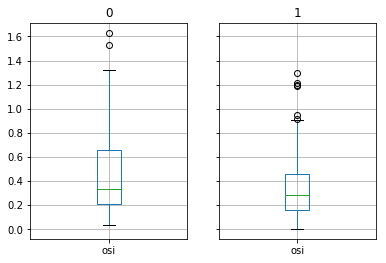

In [211]:
grouped_osi = color_osi[color_osi.r_pref > 0.02][['osi', 'color_pref']].groupby(['color_pref'])
grouped_osi.boxplot(column=['osi'])
plt.show()
plt.close()

In [212]:
t_stat, p = stats.ttest_ind(color_osi[(color_osi.color_pref == 1) & (color_osi.r_pref > 0.03)]['osi'],
                            color_osi[(color_osi.color_pref == 0) & (color_osi.r_pref > 0.03)]['osi'])
p

0.20052198772076169

NameError: name 'color_osi' is not defined